In [59]:
import os
import time
import datetime

import pandas as pd
import seaborn as sns
import numpy as np
import random

import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torch.utils.data import Dataset, DataLoader, random_split, RandomSampler, SequentialSampler

from transformers import GPT2LMHeadModel,  GPT2Tokenizer, GPT2Config, GPT2LMHeadModel
from transformers import AdamW, get_linear_schedule_with_warmup

import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\hk3pz\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [60]:
train_path = 'data/data.csv'
batch_size = 1
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
seed_val = 42

In [61]:
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [62]:
device

device(type='cuda')

In [63]:
df = pd.read_csv(train_path)  
df.head()

,id,comment
0,47326,La Passion du Christ : J’ai vraiment bien aimé...
1,30784,Predator 2 : Après le chef d’œuvre qui est le ...
2,142987,Predators : Après un premier épisode qui est u...
3,43225,Predator : Un classique du film d’action fanta...
4,61545,Prête-moi ta main : Une comédie romantique plu...


In [64]:
df.dropna(inplace=True)
comments = df.comment.copy()
comments.head()

0    La Passion du Christ : J’ai vraiment bien aimé...
1    Predator 2 : Après le chef d’œuvre qui est le ...
2    Predators : Après un premier épisode qui est u...
3    Predator : Un classique du film d’action fanta...
4    Prête-moi ta main : Une comédie romantique plu...
Name: comment, dtype: object

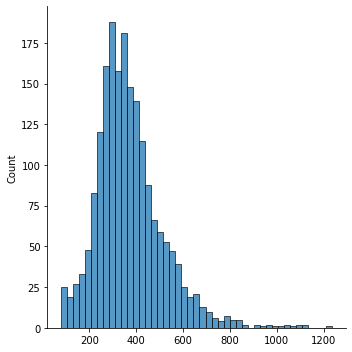

In [65]:
comment_lengths = []
for comment in comments:
    tokens = nltk.word_tokenize(comment)
    comment_lengths.append(len(tokens))
comment_lengths = np.array(comment_lengths)
sns.displot(comment_lengths)

In [66]:
np.average(comment_lengths)

372.0129600829445

In [67]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2', bos_token='<|startoftext|>', eos_token='<|endoftext|>', pad_token='<|pad|>')

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [68]:
print("The max model length is {} for this model, although the actual embedding size for GPT small is 768".format(tokenizer.model_max_length))
print("The beginning of sequence token {} token has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.bos_token_id), tokenizer.bos_token_id))
print("The end of sequence token {} has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.eos_token_id), tokenizer.eos_token_id))
print("The padding token {} has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.pad_token_id), tokenizer.pad_token_id))

The max model length is 1024 for this model, although the actual embedding size for GPT small is 768
The beginning of sequence token <|startoftext|> token has the id 50257
The end of sequence token <|endoftext|> has the id 50256
The padding token <|pad|> has the id 50258


In [69]:
class GPT2Dataset(Dataset):

    def __init__(self, txt_list, tokenizer, max_length):

        self.tokenizer = tokenizer
        self.input_ids = []
        self.attn_masks = []

        for txt in txt_list:
            encodings_dict = tokenizer('<|startoftext|>'+ txt + '<|endoftext|>', truncation=True, max_length=max_length, padding="max_length")
            self.input_ids.append(torch.tensor(encodings_dict['input_ids']))
            self.attn_masks.append(torch.tensor(encodings_dict['attention_mask']))
            
    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.attn_masks[idx] 

In [70]:
dataset = GPT2Dataset(comments, tokenizer, max_length=768)

# Split into training and validation sets
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print(f'{train_size} training samples')
print(f'{val_size} validation samples')

1736 training samples
193 validation samples


In [71]:
train_dataloader = DataLoader(
    train_dataset,
    sampler = RandomSampler(train_dataset),
    batch_size = batch_size
)

validation_dataloader = DataLoader(
    val_dataset,
    sampler = SequentialSampler(val_dataset),
    batch_size = batch_size
)

In [72]:
epochs = 5
learning_rate = 5e-4
warmup_steps = 1e2
epsilon = 1e-8
sample_every = 100
total_steps = len(train_dataloader) * epochs

In [73]:
configuration = GPT2Config.from_pretrained('gpt2', output_hidden_states=False)
model = GPT2LMHeadModel.from_pretrained("gpt2", config=configuration)
model.resize_token_embeddings(len(tokenizer))

model.to(device)

optimizer = AdamW(
    model.parameters(),
    lr = learning_rate,
    eps = epsilon
)

scheduler = get_linear_schedule_with_warmup(
    optimizer, 
    num_warmup_steps = warmup_steps, 
    num_training_steps = total_steps
)

def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round((elapsed)))))

RuntimeError: CUDA out of memory. Tried to allocate 148.00 MiB (GPU 0; 4.00 GiB total capacity; 3.09 GiB already allocated; 0 bytes free; 3.12 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
total_t0 = time.time()
training_stats = []
model = model.to(device)

for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()

    total_train_loss = 0

    model.train()

    for step, batch in enumerate(train_dataloader):

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        model.zero_grad()        

        outputs = model(
            b_input_ids,
            labels=b_labels, 
            attention_mask = b_masks,
            token_type_ids=None
        )

        loss = outputs[0]  

        batch_loss = loss.item()
        total_train_loss += batch_loss

        # Get sample every x batches.
        if step % sample_every == 0 and not step == 0:

            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}. Loss: {:>5,}.   Elapsed: {:}.'.format(step, len(train_dataloader), batch_loss, elapsed))

            model.eval()

            sample_outputs = model.generate(
                bos_token_id=random.randint(1,30000),
                do_sample=True,   
                top_k=50, 
                max_length = 200,
                top_p=0.95, 
                num_return_sequences=1
            )
            for i, sample_output in enumerate(sample_outputs):
                print("{}: {}".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))
            
            model.train()

        loss.backward()
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_train_loss / len(train_dataloader)       
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    t0 = time.time()
    model.eval()

    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)
        
        with torch.no_grad():        
            outputs = model(
                b_input_ids, 
                attention_mask = b_masks,
                labels=b_labels
            )
            loss = outputs[0]  
            
        batch_loss = loss.item()
        total_eval_loss += batch_loss        

    avg_val_loss = total_eval_loss / len(validation_dataloader)
    validation_time = format_time(time.time() - t0)    

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 5 ========
Training...


RuntimeError: CUDA out of memory. Tried to allocate 14.00 MiB (GPU 0; 4.00 GiB total capacity; 3.09 GiB already allocated; 0 bytes free; 3.12 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF